In [1]:
import pandas as pd
import bt
import talib
import requests
from dotenv import load_dotenv
import os
import certifi
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
from fpdf import FPDF
import openai
import os
from markdown import markdown
from bs4 import BeautifulSoup

In [2]:
# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment variables
api_key = os.getenv('FMP_API_KEY')

In [3]:
def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

symbol = 'BTCUSD'
url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?apikey={api_key}'
json_data = get_jsonparsed_data(url)


C:\Users\jb_sl\AppData\Local\Temp\ipykernel_22320\2312864113.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [4]:
# Convert the historical prices data to a pandas DataFrame
btc_data = json_data['historical']
df = pd.DataFrame(btc_data)

# Ensure the 'date' column is a datetime object and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Set the date as the index
df.set_index('date', inplace=True)


In [5]:
# TECHNICAL ANALYSIS
# Calculate Exponential Moving Average (EMA)
df['EMA_20'] = talib.EMA(df['close'], timeperiod=20)

# Calculate Bollinger Bands
upper_band, middle_band, lower_band = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['Upper_Band'] = upper_band
df['Middle_Band'] = middle_band
df['Lower_Band'] = lower_band

# Calculate Relative Strength Index (RSI)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)

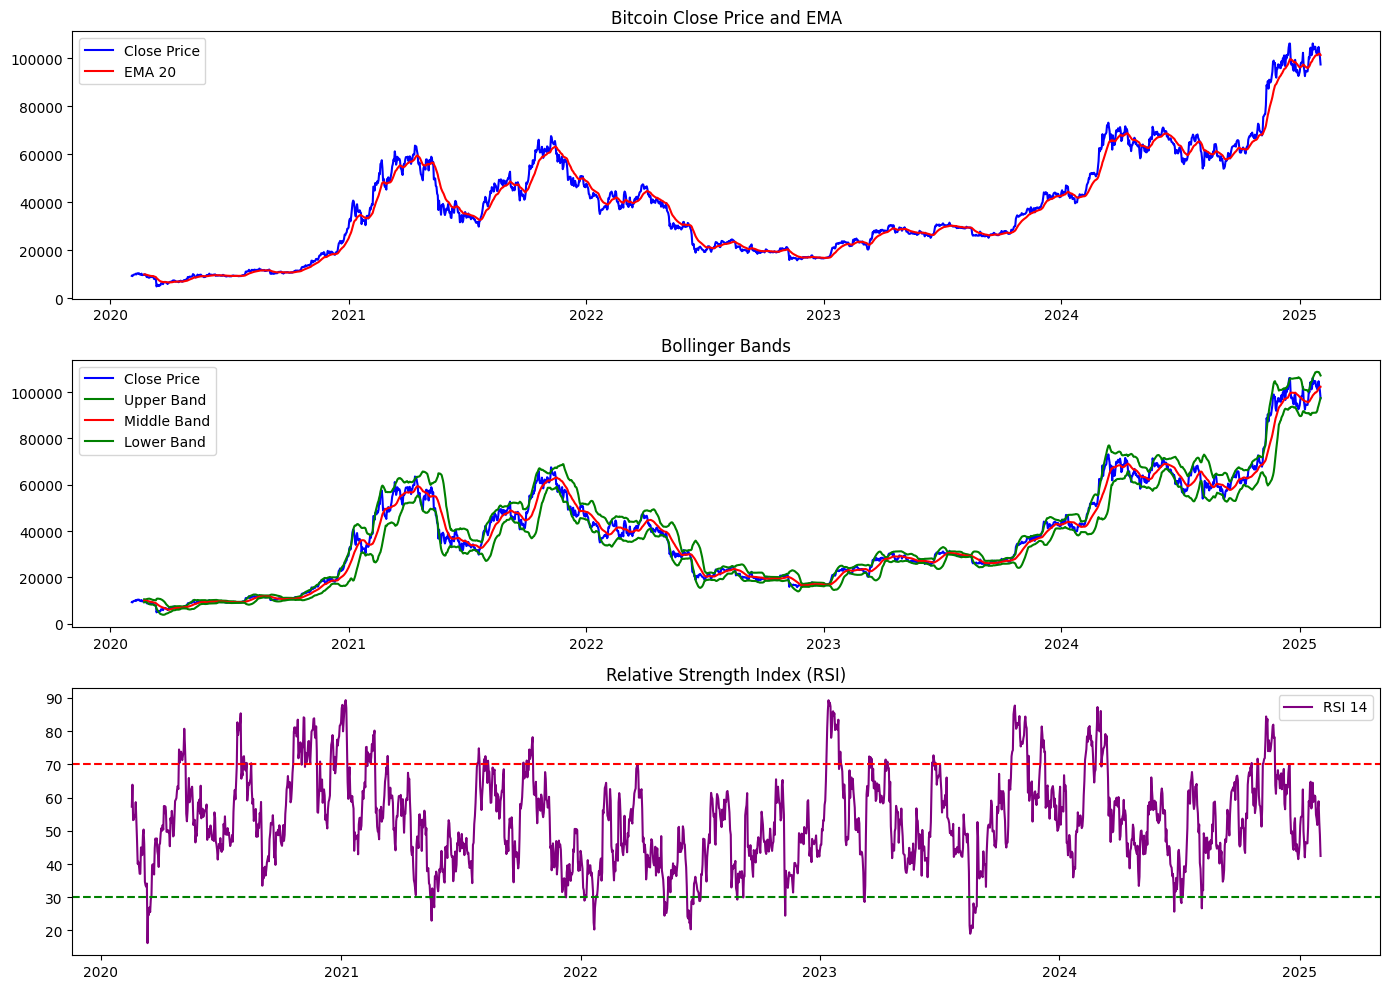

In [6]:
# Plotting the data
plt.figure(figsize=(14, 10))

# Plot close price and EMA
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['EMA_20'], label='EMA 20', color='red')
plt.title('Bitcoin Close Price and EMA')
plt.legend()

# Plot Bollinger Bands
plt.subplot(3, 1, 2)
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['Upper_Band'], label='Upper Band', color='green')
plt.plot(df.index, df['Middle_Band'], label='Middle Band', color='red')
plt.plot(df.index, df['Lower_Band'], label='Lower Band', color='green')
plt.title('Bollinger Bands')
plt.legend()

# Plot RSI
plt.subplot(3, 1, 3)
plt.plot(df.index, df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.legend()

plt.tight_layout()
plt.savefig('bitcoin_analysis_plots.png')
plt.show()

In [7]:
# Call GPT-4 to summarize the analysis

openai.api_key = os.getenv("OPENAI_API_KEY")
summary_prompt = (
        "Analyze the following technical analysis results for Bitcoin:\n"
        f"- The closing prices are: {df['close'].tail().values.tolist()}\n"
        f"- The EMA (20) is: {df['EMA_20'].tail().values.tolist()}\n"
        f"- The Bollinger Bands (Upper, Middle, Lower) are: {list(zip(df['Upper_Band'].tail().values, df['Middle_Band'].tail().values, df['Lower_Band'].tail().values))}\n"
        f"- The RSI (14) values are: {df['RSI_14'].tail().values.tolist()}\n"
        "Provide a summary of the current market trend and any notable insights based on these indicators."
    )
completion = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a financial analyst assistant."},
            {"role": "user", "content": summary_prompt}
        ],
        max_tokens=500
    )
print("Assistant: " + completion.choices[0].message.content)


Assistant: Based on the provided technical analysis indicators for Bitcoin, here's a summary of the current market trend and notable insights:

1. **Closing Prices and Trend:**
   - The closing prices for Bitcoin are exhibiting a downward trend over the recent period, declining from 103747.25 to 97405.5. This indicates selling pressure and a bearish sentiment in the market.

2. **Exponential Moving Average (EMA 20):**
   - The 20-day EMA values are relatively stable but are starting to slightly decrease towards the end, from 101538.75 to 101360.29, which suggests a bearish crossover is forming as the actual price is consistently below the EMA. This confirms that the short-term trend is bearish.

3. **Bollinger Bands:**
   - The Bollinger Bands show a widening at the beginning, which typically indicates increasing volatility. However, towards the latest data, the bands are narrowing slightly, suggesting that volatility is decreasing. The closing prices have moved from above the middle b

In [8]:
# Extract the summary from the OpenAI completion response
summary = completion.choices[0].message.content

# Convert Markdown to HTML
html_content = markdown(summary)

# Extract plain text from HTML using BeautifulSoup for PDF rendering
soup = BeautifulSoup(html_content, "html.parser")
plain_text = soup.get_text()

# Create a PDF report
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

# Add title
pdf.cell(200, 10, txt="Bitcoin Technical Analysis Summary", ln=True, align='C')
pdf.ln(10)

# Add the Markdown content (as plain text) to the PDF
pdf.multi_cell(0, 10, txt=plain_text)

# Add plots to PDF
pdf.ln(10)
pdf.image('bitcoin_analysis_plots.png', x=10, w=190)

# Save the PDF to the current filepath
pdf_file_path = "bitcoin_analysis_report.pdf"
pdf.output(pdf_file_path)

print(f"PDF report generated and saved to {pdf_file_path}")

PDF report generated and saved to bitcoin_analysis_report.pdf
